In [1]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=879419f9e67cd350a19d2b234894a362dc063360ba4479e815875a4ebaca44b6
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import json
from pprint import pprint
from PIL import Image
from sentence_transformers import SentenceTransformer, util
import glob
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
json1 = "drive/MyDrive/Colab Notebooks/pizza_00_01.json"
json2 = "drive/MyDrive/Colab Notebooks/pizza_00_02.json"

img1_name = "drive/MyDrive/Colab Notebooks/frame0_01.jpg"
img2_name = "drive/MyDrive/Colab Notebooks/frame0_02.jpg"

In [5]:
# find the bounding boxes of the person defined by detected openpose joints
def find_ranges(input_list, x_min, y_min, x_max, y_max):
    if len(input_list) > 3:
        j = 0
        while j < len(input_list) - 2:
            x = input_list[j]
            y = input_list[j+1]
            conf = input_list[j+2]
            if conf > 0.5:
                if x < x_min:
                    x_min = x
                if x > x_max:
                    x_max = x

                if y < y_min:
                    y_min = y
                if y > y_max:
                    y_max = y
            j += 3

    return x_min, y_min, x_max, y_max

# crop the images in accordance to the openpose detections to get subimages
# with detected people
def get_subimages(json_file, img_name):
    with open(json_file, 'r') as f:
        kp = json.load(f)

    people = kp["people"]
    ranges = {}
    for i, person in enumerate(people):
        x_min = 100000000
        y_min = 100000000
        x_max = -100
        y_max = -100

        x_min, y_min, x_max, y_max = find_ranges(person["pose_keypoints_2d"], x_min, y_min, x_max, y_max)
        x_min, y_min, x_max, y_max = find_ranges(person["face_keypoints_2d"], x_min, y_min, x_max, y_max)
        x_min, y_min, x_max, y_max = find_ranges(person["hand_left_keypoints_2d"], x_min, y_min, x_max, y_max)
        x_min, y_min, x_max, y_max = find_ranges(person["hand_right_keypoints_2d"], x_min, y_min, x_max, y_max)

        ranges[i] = [x_min, y_min, x_max, y_max]

    im = Image.open(img_name)
    subimages = []
    for id in ranges:
        subimages.append(im.crop(ranges[id]))

    return subimages

In [6]:
#########################
## ORB detector
#########################
def orb_det(img1, img2):
  orb = cv.ORB_create()
  kp1, des1 = orb.detectAndCompute(img1,None)
  kp2, des2 = orb.detectAndCompute(img2,None)
  if des1 is not None and des2 is not None:
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches_orb = bf.match(des1,des2)
    matches_orb = sorted(matches_orb, key = lambda x:x.distance)
    img3 = cv.drawMatches(img1,kp1,img2,kp2,matches_orb[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return img3, len(matches_orb)
  else:
    img3 = cv.drawMatches(img1,kp1,img2,kp2,None,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return img3, 0

##############################
## SIFT detector
##############################
def sift_det(img1, img2):
  sift = cv.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1,None)
  kp2, des2 = sift.detectAndCompute(img2,None)
  if des1 is not None and des2 is not None:
    bf = cv.BFMatcher()
    matches_sift = bf.knnMatch(des1,des2,k=2)
    good = []
    for m,n in matches_sift:
        if m.distance < 0.75*n.distance:
            good.append([m])
    img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return img3, len(good)
  else:
    img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,None,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return img3, 0

def show(img):
  plt.imshow(img),plt.show()

In [7]:
#####################
## CLIP matcher
#####################
def clip_best_matches(subimages1, subimages2):
  comparisons = []
  for el in subimages1:
      tmp = []
      tmp.append(el)
      for match in subimages2:
          tmp.append(match)

      comparisons.append(tmp)

  model = SentenceTransformer('clip-ViT-B-32')
  matches = []
  for comp in comparisons:
      encoded_image = model.encode(comp, batch_size=128, convert_to_tensor=True, show_progress_bar=True)
      processed_images = util.paraphrase_mining_embeddings(encoded_image)

      print('Finding best matched images...')
      best_match = processed_images[0]
      print(best_match)
      matches.append(best_match)

  return matches

In [8]:
# get the subimages of people in both views
im1_sub = get_subimages(json1, img1_name)
im2_sub = get_subimages(json2, img2_name)

In [16]:
pil1 = im1_sub[0]
pil2 = im2_sub[0]

img1 = np.array(pil1)
img2 = np.array(pil2)

29


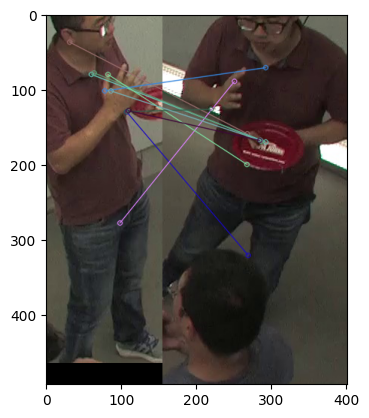

In [17]:
img3, no_matches = orb_det(img1, img2)
print(no_matches)
show(img3)

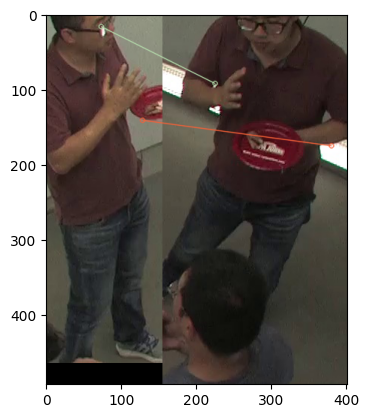

2


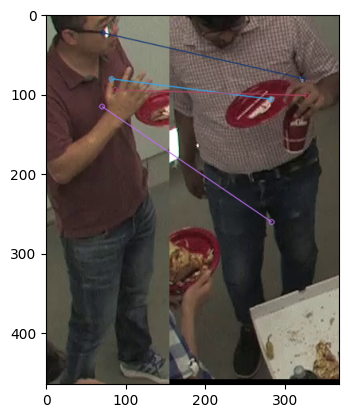

4


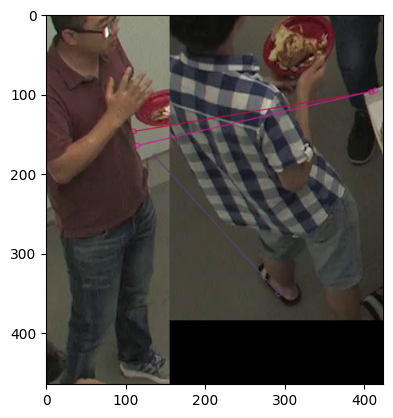

3


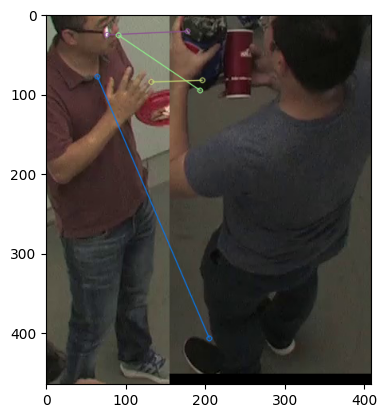

4


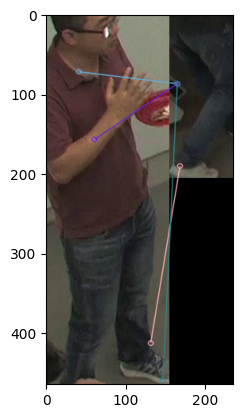

4


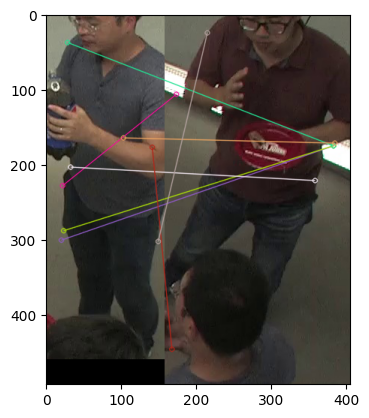

8


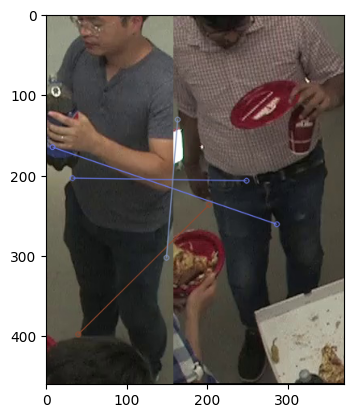

4


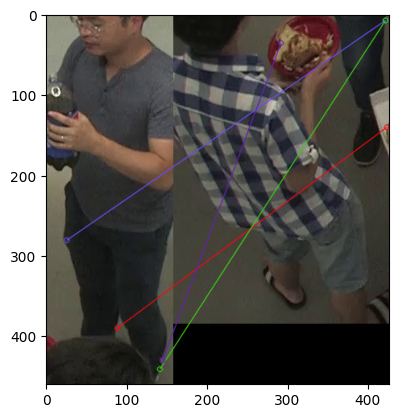

4


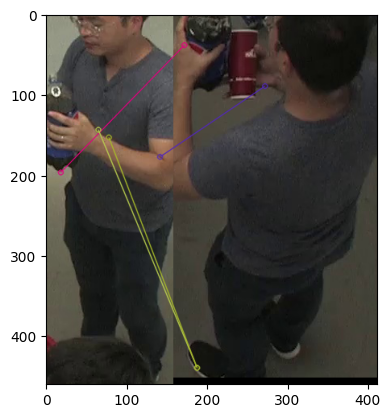

4


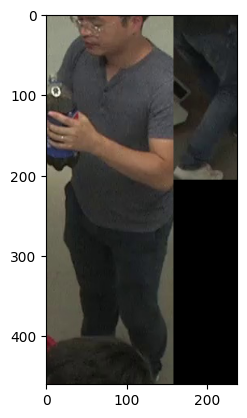

0


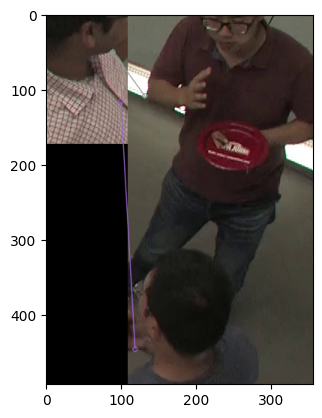

2


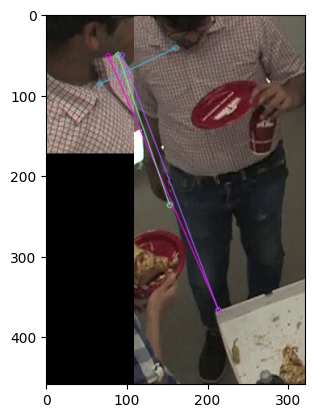

4


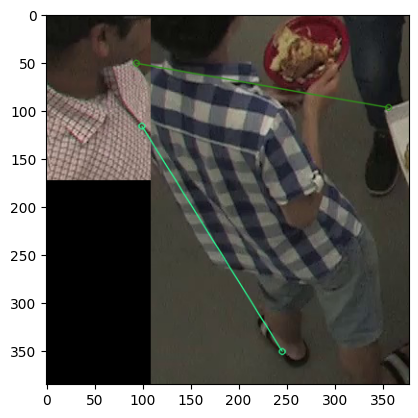

2


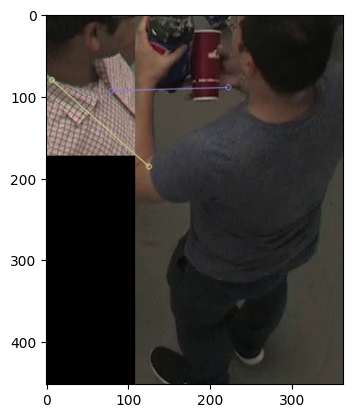

2


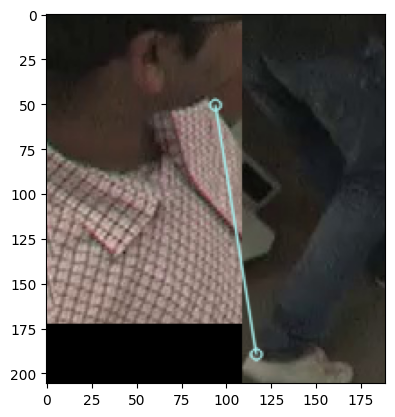

1


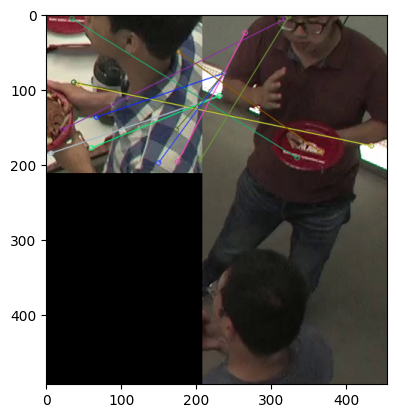

13


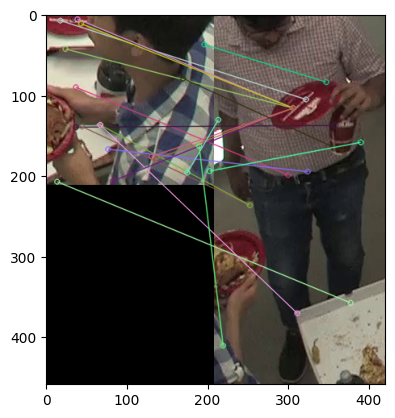

20


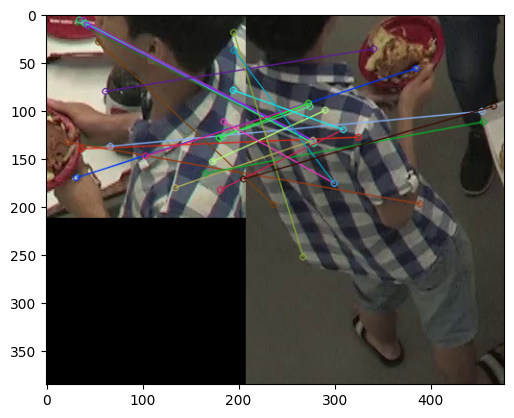

24


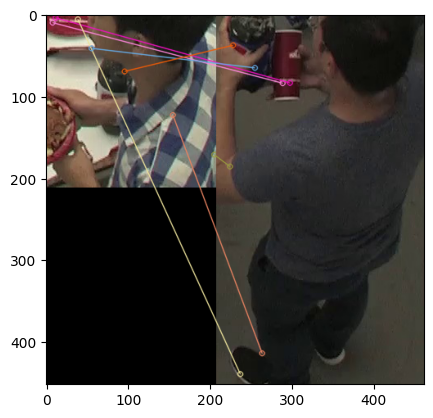

7


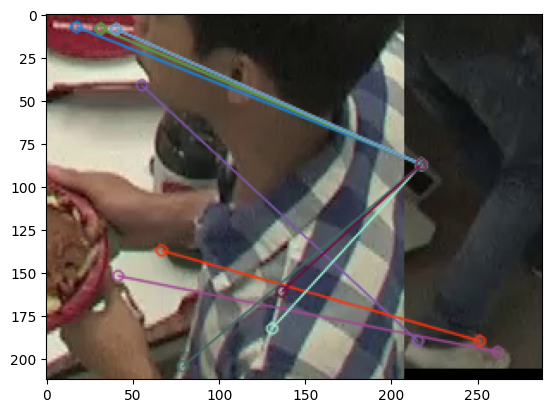

11


In [18]:
for pil1 in im1_sub:
  for pil2 in im2_sub:
    img1 = np.array(pil1)
    img2 = np.array(pil2)
    img3, no = sift_det(img1, img2)
    show(img3)
    print(no)


In [19]:
clip_best_matches(im1_sub, im2_sub)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Finding best matched images...
[0.8941298723220825, 0, 4]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Finding best matched images...
[0.9087609052658081, 4, 0]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Finding best matched images...
[0.8547821044921875, 1, 2]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Finding best matched images...
[0.8547821044921875, 1, 2]


[[0.8941298723220825, 0, 4],
 [0.9087609052658081, 4, 0],
 [0.8547821044921875, 1, 2],
 [0.8547821044921875, 1, 2]]